In [90]:
import cv2, torch
import sys
sys.path.append('../src')
from ImageToStringPreprocessing import ImageToStringPreprocessing
from ImageToStringNet import ImageToStringNet, classes as ImageToStringClasses

In [91]:
image_path = 'giraffa100%.png'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

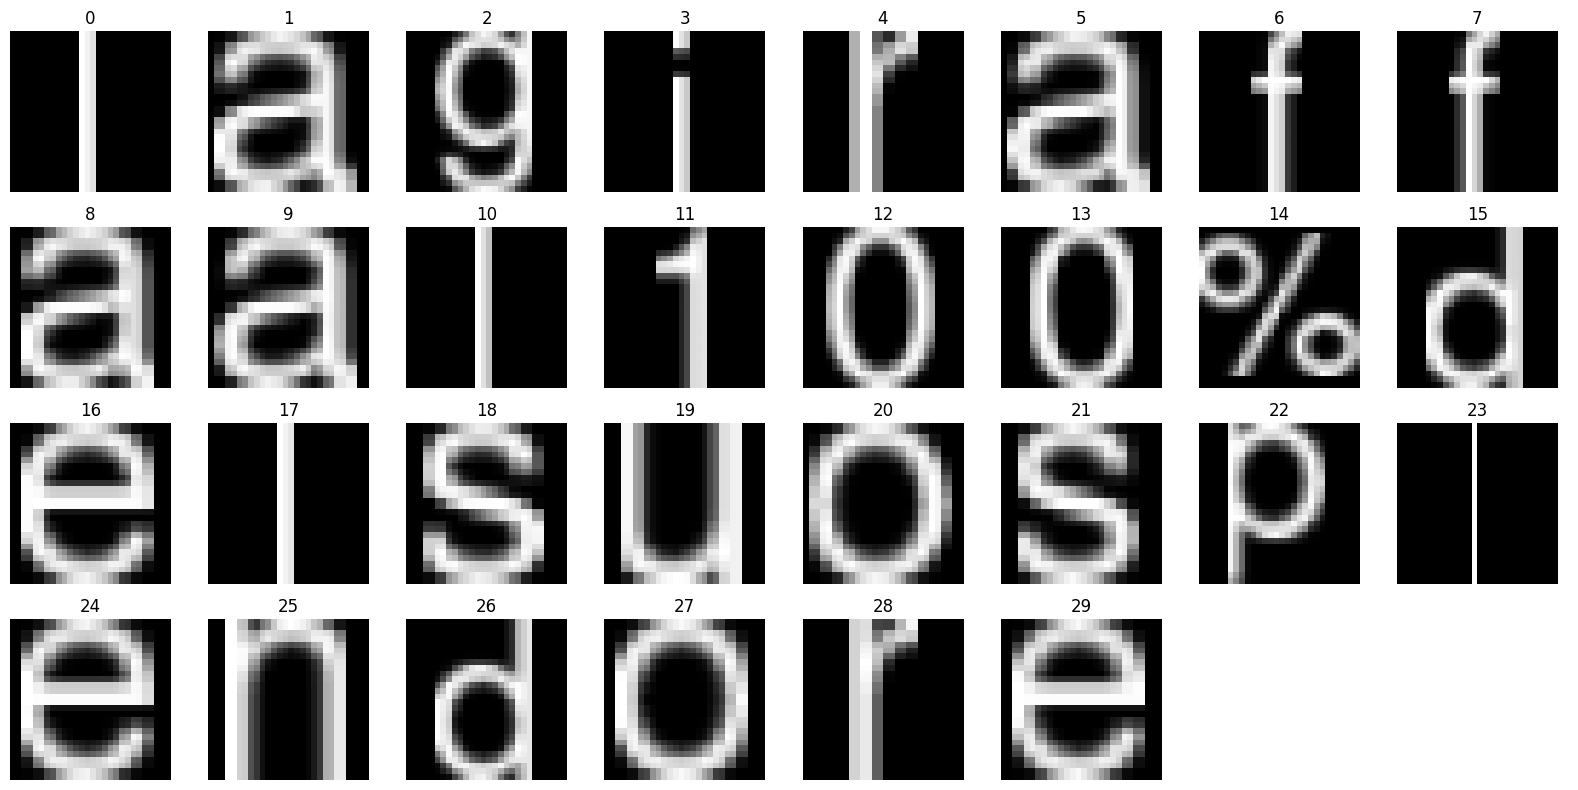

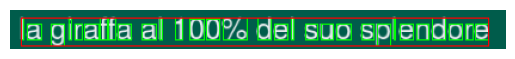

In [92]:
preprocessor = ImageToStringPreprocessing(image_rgb)

preprocessor.show_letters()
preprocessor.show_bboxed_image()

In [93]:
preprocessor.get_info()[0]

{'bboxes': (np.int32(9), np.int32(7), np.int32(2), np.int32(18)),
 'img': array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213,

In [94]:
preprocessor.get_info()[0]['img'].shape

(28, 28)

In [95]:
from torch import Tensor

In [96]:
class ImageToStringPostprocessing:
    def __init__(self):
        pass

    def add_spaces(str, info):
        return str

In [123]:
class ImageToStringClassifier:
    __MODEL_PATH = '../src/model_weights.pth'
    def __init__(self, image_path):

        self.net = ImageToStringNet()
        self.net.load_state_dict(torch.load(self.__MODEL_PATH, weights_only=True))
        self.net.eval()

        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        self.preprocessor = ImageToStringPreprocessing(image_rgb)
        self.postprocessor = ImageToStringPostprocessing()

    def _classify(self):

        device = torch.device('xpu' if torch.xpu.is_available() else 'cpu')

        images = Tensor([x['img'][None, ...] for x in preprocessor.get_info()]).to(device)
        top_margins = Tensor([x['dist_top'] for x in preprocessor.get_info()]).to(device)
        bottom_margins = Tensor([x['dist_bottom'] for x in preprocessor.get_info()]).to(device)

        self.net.to(device)

        # Perform inference
        with torch.no_grad():
            outputs = self.net(images, top_margins, bottom_margins)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()
        
        return [ImageToStringClasses[i] for i in predicted]
    
    def _add_spaces(self, labels):
        # Add spaces using heuristics
        dist_dx = [x['dist_dx'] for x in preprocessor.get_info() if x['dist_dx'] is not None]

        dist_dx_min = min(dist_dx)
        dist_dx_max = max(dist_dx)

        space_indexes = [i for i, v in enumerate(dist_dx) if v is not None and v > (dist_dx_min + dist_dx_max) * 0.6]

        # Insert spaces at the specified positions in the labels list
        labels_with_spaces = labels.copy()

        for idx in reversed(space_indexes):
            labels_with_spaces.insert(idx + 1, ' ')

        return "".join(labels_with_spaces)

    def get_string(self):
        # classify using the model
        labels = list(self._classify())

        # add spaces using heuristics
        labels_with_spaces = self._add_spaces(labels)

        return "".join(labels_with_spaces)
        

In [124]:
classifier = ImageToStringClassifier(image_path)
classifier.get_string()

'la giraffa al 100% del suO splendore'

In [99]:
#[(i, x['dist_top'], x['dist_bottom']) for i, x in enumerate(classifier.preprocessor.get_info())]

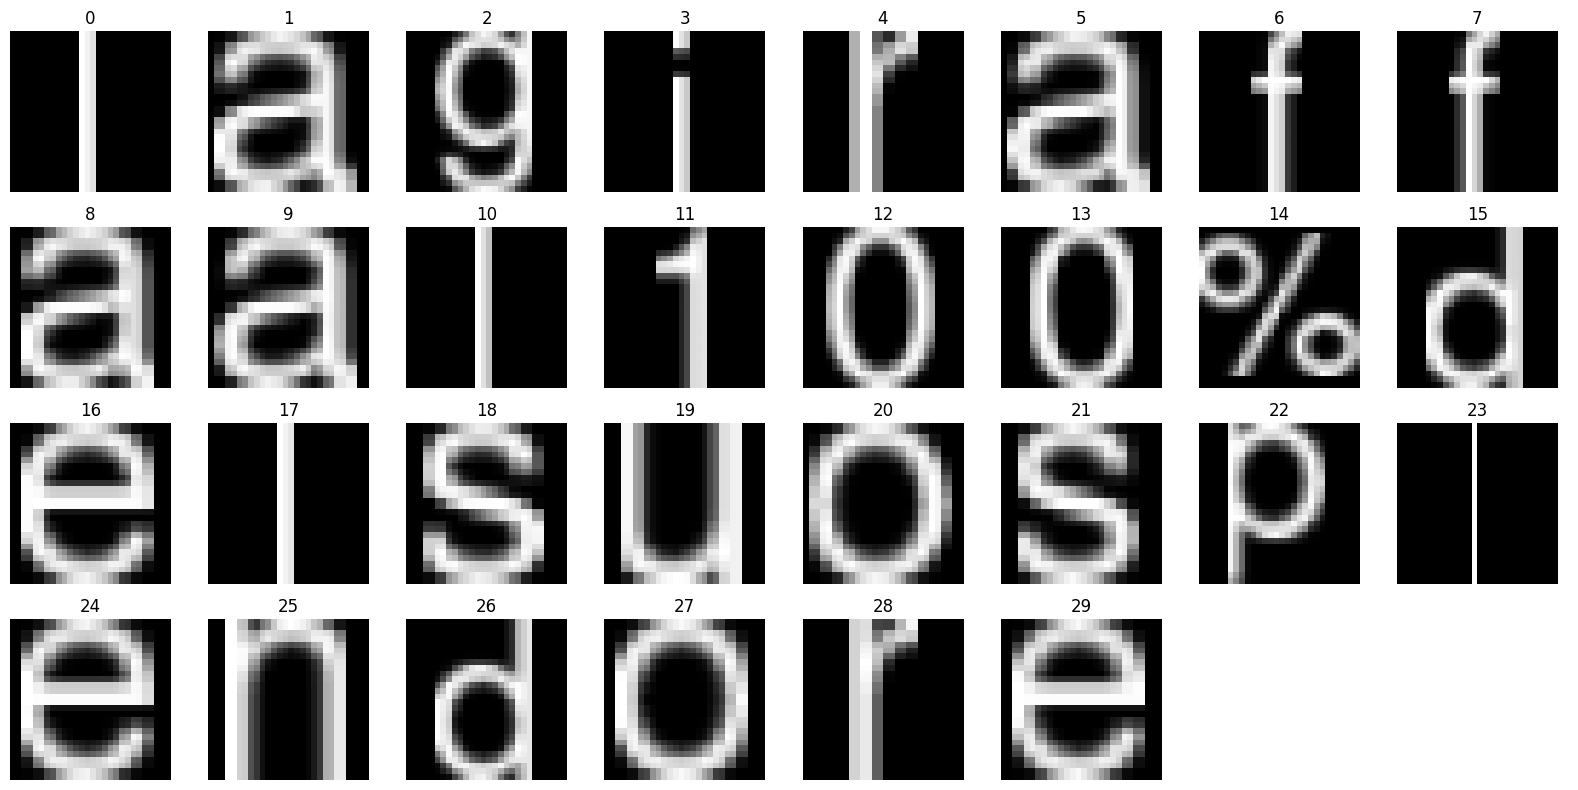

In [100]:
classifier.preprocessor.show_letters()

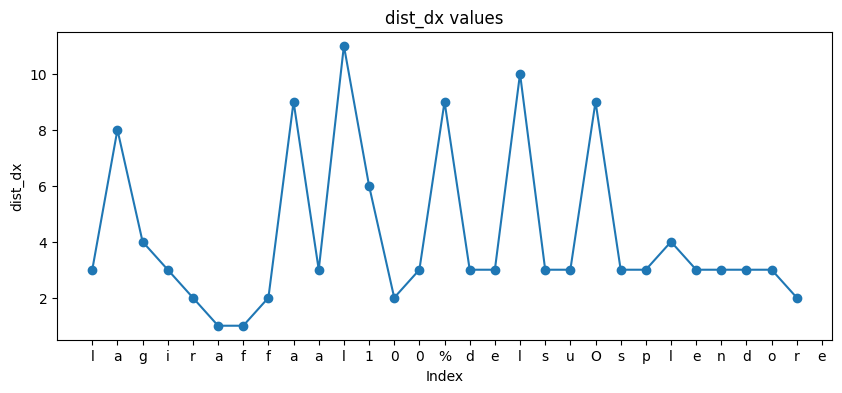

In [102]:
import matplotlib.pyplot as plt

dist_dx = [x['dist_dx'] for x in preprocessor.get_info() if x['dist_dx'] is not None]
labels = list(classifier._classify())
plt.figure(figsize=(10, 4))
plt.plot(dist_dx, marker='o')
plt.title('dist_dx values')
plt.xlabel('Index')
plt.ylabel('dist_dx')
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.show()